In [14]:
import os 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from tkinter import Tcl

import tifffile

from PIL import Image


from scipy import ndimage as nd

import pypore3d 
from pypore3d import *
from pypore3d.p3dFiltPy import *
# from pypore3d.p3dBlobPy import *
# from pypore3d.p3dSkelPy import *
# from pypore3d.p3dSITKPy import *

import os
 
from poreUtils import *

from scipy.ndimage import distance_transform_edt


In [2]:
# Path to the slices 
data_dir = 'D:\sagar\Data\MD_1264_A2_1_Z3.3mm\slices'
tiffs = os.listdir(data_dir)

In [3]:
# Reading all the slices in a Volume 
vol = np.empty(shape=(1700, 3691, 3691), dtype=np.float32)
for i, fname in enumerate(tqdm(tiffs)):
    im = Image.open(os.path.join(data_dir, fname))
    imarray = np.array(im)
    vol[i, :, :] = imarray

100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [05:48<00:00,  4.88it/s]


In [4]:
# Slice number from a roi 
slice_no = 650 

# plot the slice from the entire data 

# plot the the roi on top of the slice 

# 


In [5]:
# the list of ROI 
roi_dir = 'D:\\sagar\\Data\\MD_1264_A2_1_Z3.3mm\\roi'
rois = os.listdir(roi_dir)


In [6]:
# Reading the image 
img_path = 'D:\\sagar\\Data\MD_1264_A2_1_Z3.3mm\\result\\600-900x1000-1300x1600-1900_8bit.raw'

x, y, z = 300, 300, 300

volc = py_p3dReadRaw8(img_path, x, y, z)
# Appying Median filter for removing noise
volc = py_p3dMedianFilter8(volc, x, y, z, width=3)
# convert it to numpy array for manual thresholding and a bit processing which are easy in numpy array
roi = swigObjt2uint8Array(volc, x, y, z) 

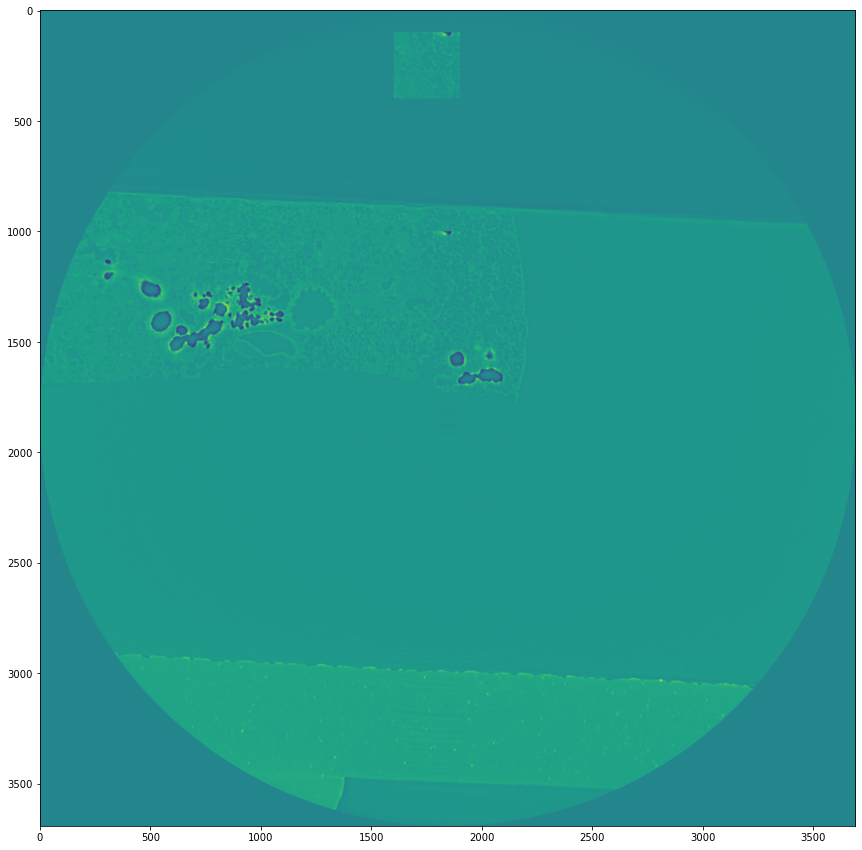

In [27]:

vol[slice_no, 100:400, 1600:1900] = raw_vol[0, :, :]
plt.figure(figsize=(26, 15))
plt.imshow(vol[slice_no, ...])
#plt.show()
plt.imshow(vol[50, ...], alpha=0.5)

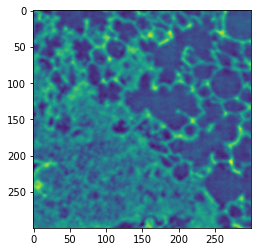

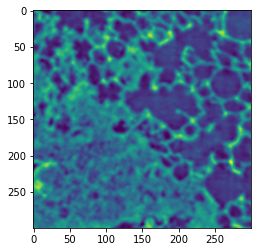

In [18]:
plt.imshow(raw_vol[50, :, :])
plt.show()
plt.imshow(vol[650, 1000:1300, 1600:1900])
plt.show()

In [15]:
file_path = 'D:\\sagar\\Data\\MD_1264_A2_1_Z3.3mm\\roi\\600-900x1000-1300x1600-1900'
raw_vol = []
#sorting the slices according to their names like in windows 
slices = Tcl().call('lsort', '-dict', os.listdir(file_path))
for aSlice in slices:
    img = Image.open(os.path.join(file_path, aSlice))
    imgarray = np.array(img)
    raw_vol.append(imgarray)

In [16]:
raw_vol = np.asarray(raw_vol)

In [19]:
raw_vol.dtype

dtype('float32')

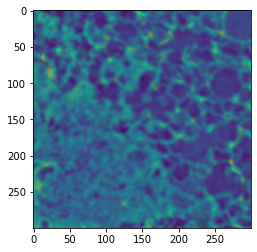

In [31]:
plt.imshow(roi[50, ...], )
plt.imshow(roi[20, ...], alpha=0.5)
plt.show()